In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

# Path to your CSV file on Google Drive
file_path = '/content/drive/MyDrive/data_folder/Collected_File.csv'

# Read the CSV file
df_Read = pd.read_csv(file_path)

In [ ]:
import pandas as pd

# Assuming df_Read is already loaded

# Convert datetime column to datetime type if not already
df_Read['datetime'] = pd.to_datetime(df_Read['datetime'])

# Group by CellID and datetime, summing the internet traffic
df_grouped = df_Read.groupby(['CellID', 'datetime'], as_index=False)['internet'].sum()

# Set datetime as index
df_grouped = df_grouped.set_index('datetime')

print(df_grouped.head())
print(f"New shape: {df_grouped.shape}")

                     CellID    internet
datetime                               
2013-11-01 00:00:00    4546  503.736286
2013-11-01 00:10:00    4546  551.313816
2013-11-01 00:20:00    4546  527.631979
2013-11-01 00:30:00    4546  569.648635
2013-11-01 00:40:00    4546  674.550847
New shape: (820200, 2)


In [ ]:
# Filter only CellID 4855
cell_4755 = df_grouped[df_grouped['CellID'] == 4755].copy()

# Drop CellID column since it's constant now
cell_4755.drop(columns='CellID', inplace=True)

# Sort by datetime just in case
cell_4755 = cell_4755.sort_index()

print(cell_4755.head())
print(cell_4755.shape)

                        internet
datetime                        
2013-11-01 00:00:00  1882.835224
2013-11-01 00:10:00  1792.001814
2013-11-01 00:20:00  1721.562928
2013-11-01 00:30:00  1608.051995
2013-11-01 00:40:00  1533.467322
(8202, 1)


In [ ]:
# Extract data between 2013-11-05 and 2013-12-05 (inclusive)
start_date = '2013-11-05'
end_date = '2013-12-05'

cell_4755_subset = cell_4755.loc[start_date:end_date].copy()

print(cell_4755_subset.head())
print(cell_4755_subset.shape)

                       internet
datetime                       
2013-11-05 00:00:00  637.314733
2013-11-05 00:10:00  617.837502
2013-11-05 00:20:00  594.127909
2013-11-05 00:30:00  621.263989
2013-11-05 00:40:00  610.602649
(4464, 1)


In [ ]:
is_regular = (cell_4755_subset.index.to_series().diff().dropna() == pd.Timedelta('10min')).all()
print("Regular 10min interval:", is_regular)


Regular 10min interval: True


In [ ]:
import pandas as pd

cell_4755_subset_Model = cell_4755_subset.copy()

print(cell_4755_subset_Model.head())
print(f"Data shape: {cell_4755_subset_Model.shape}")


                       internet
datetime                       
2013-11-05 00:00:00  637.314733
2013-11-05 00:10:00  617.837502
2013-11-05 00:20:00  594.127909
2013-11-05 00:30:00  621.263989
2013-11-05 00:40:00  610.602649
Data shape: (4464, 1)


In [ ]:
is_regular = (cell_4755_subset_Model.index.to_series().diff().dropna() == pd.Timedelta('10min')).all()
print("Regular 10min interval:", is_regular)


Regular 10min interval: True


In [ ]:
# Create the expected full 10-minute time index
full_index = pd.date_range(
    start=cell_4755_subset_Model.index.min(),
    end=cell_4755_subset_Model.index.max(),
    freq='10min'
)

# Find missing timestamps
missing = full_index.difference(cell_4755_subset_Model.index)
print(f"Number of missing timestamps: {len(missing)}")
print("First 10 missing timestamps:")
print(missing[:10])


Number of missing timestamps: 0
First 10 missing timestamps:
DatetimeIndex([], dtype='datetime64[ns]', freq='10min')


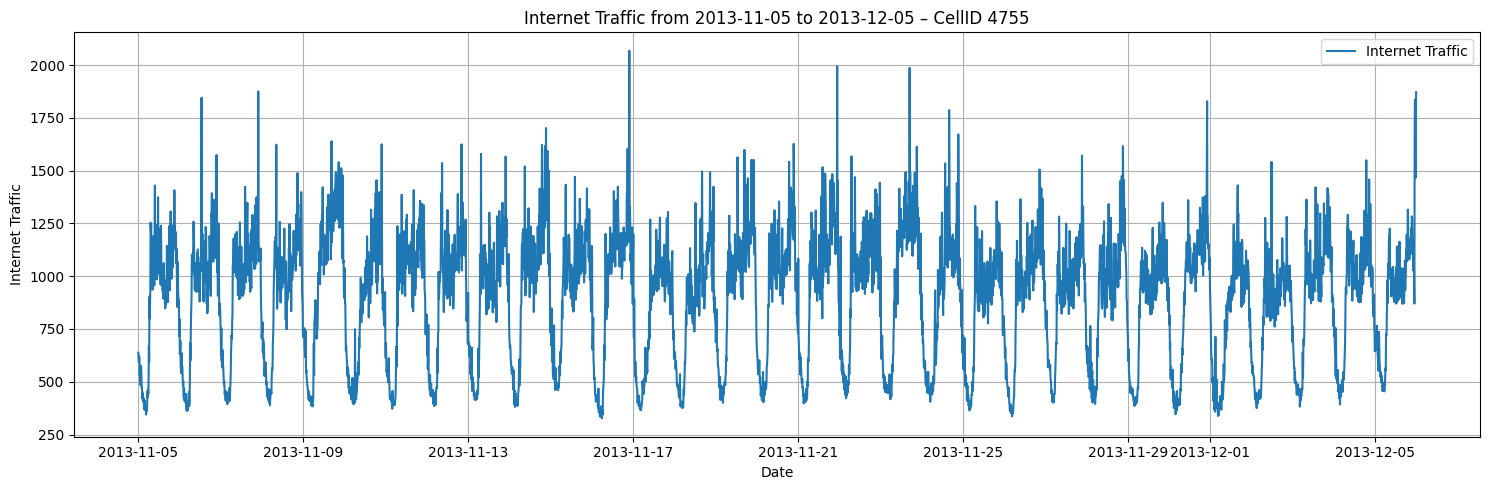

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.plot(cell_4755_subset_Model.index, cell_4755_subset_Model['internet'], label='Internet Traffic')
plt.title('Internet Traffic from 2013-11-05 to 2013-12-05 – CellID 4755')
plt.xlabel('Date')
plt.ylabel('Internet Traffic')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


outliers

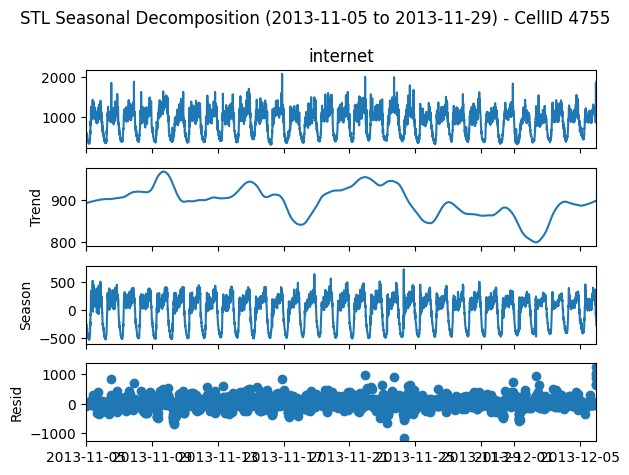

In [ ]:
from statsmodels.tsa.seasonal import STL
import matplotlib.pyplot as plt

stl = STL(cell_4755_subset_Model['internet'], period=144, robust=True)  # 144 = daily cycle
res = stl.fit()

res.plot()
plt.suptitle('STL Seasonal Decomposition (2013-11-05 to 2013-11-29) - CellID 4755')
plt.tight_layout()
plt.show()


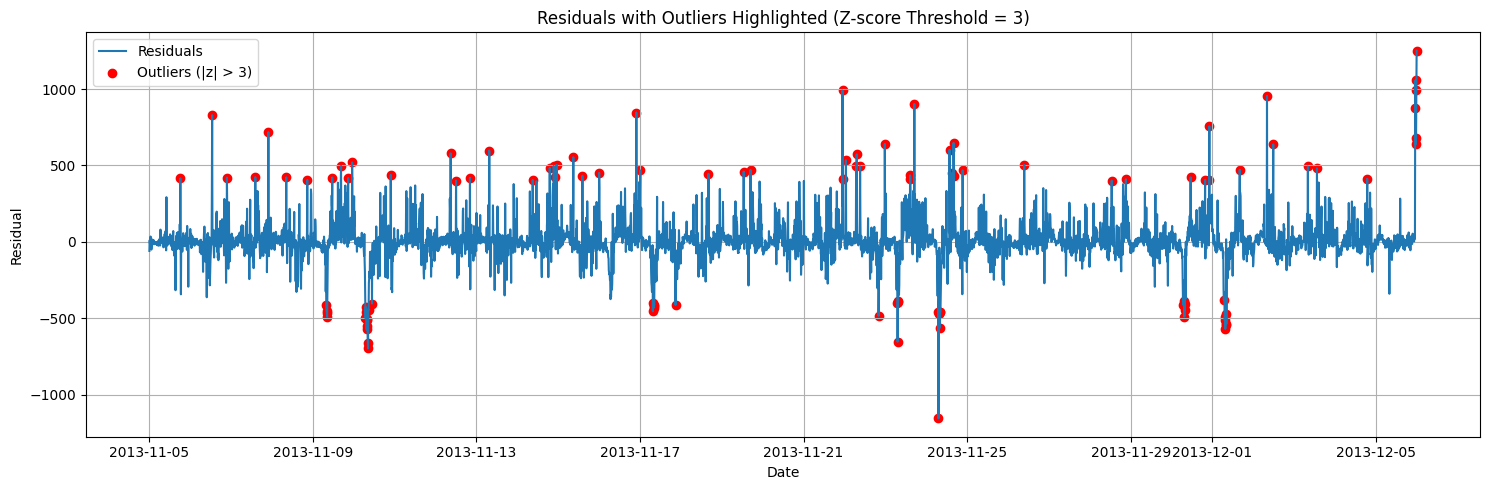

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore

# Extract residuals from STL result
residuals = res.resid

# Calculate z-score of residuals
z_scores = zscore(residuals)

# Define an outlier threshold (commonly 3 or -3)
threshold = 3

# Identify outliers
outliers = np.where(np.abs(z_scores) > threshold)[0]

# Plot residuals and mark outliers
plt.figure(figsize=(15, 5))
plt.plot(residuals.index, residuals, label='Residuals')
plt.scatter(residuals.index[outliers], residuals.iloc[outliers], color='red', label='Outliers (|z| > 3)')
plt.title('Residuals with Outliers Highlighted (Z-score Threshold = 3)')
plt.xlabel('Date')
plt.ylabel('Residual')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd

# Create a DataFrame with residuals and z-scores
residuals_df = pd.DataFrame({
    'Residual': residuals,
    'Z_score': z_scores
})

# Filter the outliers (|z| > 3)
outliers_df = residuals_df[np.abs(residuals_df['Z_score']) > 3]

# Display number of outliers
print(f"Number of outliers detected: {len(outliers_df)}")

# Show detailed info: date, residual, z-score
print(outliers_df)


Number of outliers detected: 110
                        Residual   Z_score
datetime                                  
2013-11-05 18:10:00   415.165198  3.117215
2013-11-06 12:50:00   828.808623  6.306942
2013-11-06 21:30:00   420.802654  3.160687
2013-11-07 14:10:00   423.878022  3.184402
2013-11-07 21:50:00   718.281116  5.454632
...                          ...       ...
2013-12-05 23:10:00  1058.476187  8.077977
2013-12-05 23:20:00   639.930340  4.850446
2013-12-05 23:30:00   681.493664  5.170953
2013-12-05 23:40:00   995.110420  7.589345
2013-12-05 23:50:00  1251.184072  9.564004

[110 rows x 2 columns]


In [ ]:
# Get timestamps of outliers
outlier_timestamps = outliers_df.index

# Remove these timestamps from the original data
cell_4755_subset_Model = cell_4755_subset_Model.drop(index=outlier_timestamps)

print(f"Original data shape: {cell_4755_subset_Model.shape}")
print(f"Cleaned data shape: {cell_4755_subset_Model.shape}")


Original data shape: (4354, 1)
Cleaned data shape: (4354, 1)


In [ ]:
is_regular = (cell_4755_subset_Model.index.to_series().diff().dropna() == pd.Timedelta('10min')).all()
print("Regular 10min interval:", is_regular)


Regular 10min interval: False


In [ ]:
# Create the expected full 10-minute time index
full_index = pd.date_range(
    start=cell_4755_subset_Model.index.min(),
    end=cell_4755_subset_Model.index.max(),
    freq='10min'
)

# Find missing timestamps
missing = full_index.difference(cell_4755_subset_Model.index)
print(f"Number of missing timestamps: {len(missing)}")
print("First 10 missing timestamps:")
print(missing[:10])


Number of missing timestamps: 104
First 10 missing timestamps:
DatetimeIndex(['2013-11-05 18:10:00', '2013-11-06 12:50:00',
               '2013-11-06 21:30:00', '2013-11-07 14:10:00',
               '2013-11-07 21:50:00', '2013-11-08 08:20:00',
               '2013-11-08 20:40:00', '2013-11-09 07:50:00',
               '2013-11-09 08:00:00', '2013-11-09 08:10:00'],
              dtype='datetime64[ns]', freq=None)


In [ ]:
import numpy as np
import pandas as pd

def seasonal_average_fill(series, seasonal_period=144, num_lags=4):
    filled = series.copy()

    for i in range(len(filled)):
        if pd.isna(filled.iloc[i]):
            values = []
            for lag in range(1, num_lags + 1):
                j = i - seasonal_period * lag
                if j >= 0 and not pd.isna(filled.iloc[j]):
                    values.append(filled.iloc[j])
            if values:
                filled.iloc[i] = np.mean(values)

    return filled


In [ ]:
cell_4755_filled = cell_4755_subset_Model.copy()

# Reinsert dropped timestamps with NaN
for timestamp in outlier_timestamps:
    if timestamp not in cell_4755_filled.index:
        cell_4755_filled.loc[timestamp] = [np.nan]

cell_4755_filled = cell_4755_filled.sort_index()

# Apply seasonal average fill
cell_4755_filled['internet'] = seasonal_average_fill(
    cell_4755_filled['internet'],
    seasonal_period=144,  # 1 day lag (10-min intervals)
    num_lags=4            # Use last 4 days
)


In [ ]:
# Step 5: Rename back
cell_4755_subset_Model = cell_4755_filled

In [ ]:
is_regular = (cell_4755_subset_Model.index.to_series().diff().dropna() == pd.Timedelta('10min')).all()
print("Regular 10min interval:", is_regular)


Regular 10min interval: True


In [ ]:
# Create the expected full 10-minute time index
full_index = pd.date_range(
    start=cell_4755_subset_Model.index.min(),
    end=cell_4755_subset_Model.index.max(),
    freq='10min'
)

# Find missing timestamps
missing = full_index.difference(cell_4755_subset_Model.index)
print(f"Number of missing timestamps: {len(missing)}")
print("First 10 missing timestamps:")
print(missing[:10])


Number of missing timestamps: 0
First 10 missing timestamps:
DatetimeIndex([], dtype='datetime64[ns]', freq='10min')


Try the Basic Prophet

In [ ]:
print(cell_4755_subset_Model.shape)

(4464, 1)


seasonality

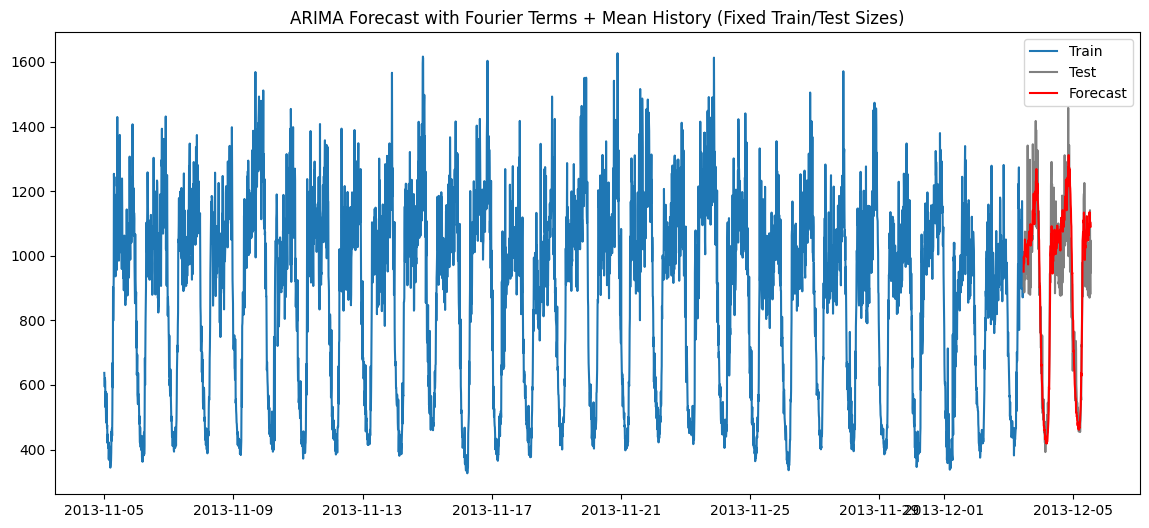

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt

# The original series
y = cell_4755_subset_Model['internet']
y = y.asfreq('10min')  # explicitly set frequency


# Step 1: Fixed train and test size
train_size = 4100
test_size = 300

y_train = y.iloc[:train_size]
y_test = y.iloc[train_size:train_size + test_size]

# Step 2: Define function for Fourier terms
def create_fourier_terms(index, period, order, prefix):
    t = np.arange(len(index))
    terms = {}
    for k in range(1, order + 1):
        terms[f'{prefix}_sin_{k}'] = np.sin(2 * np.pi * k * t / period)
        terms[f'{prefix}_cos_{k}'] = np.cos(2 * np.pi * k * t / period)
    return pd.DataFrame(terms, index=index)

# Harmonic parameters
seasonal_period = 144  # daily seasonality for 10-min intervals
seasonal_order = 3
trend_order = 2

# Step 3: Generate seasonal/trend Fourier terms
seasonal_train = create_fourier_terms(y_train.index, seasonal_period, seasonal_order, 'seasonal')
trend_train = create_fourier_terms(y_train.index, len(y_train), trend_order, 'trend')
exog_train = pd.concat([seasonal_train, trend_train], axis=1)

seasonal_test = create_fourier_terms(y_test.index, seasonal_period, seasonal_order, 'seasonal')
trend_test = create_fourier_terms(y_test.index, len(y_train), trend_order, 'trend')  # use train length for trend
exog_test = pd.concat([seasonal_test, trend_test], axis=1)

# Step 4: Calculate mean history from train data only
time_index_train = y_train.index.time
grouped_means = y_train.groupby(time_index_train).mean()
#mean_of_means = grouped_means.mean()


# mean per 10-minute period across train days
mean_by_period = y_train.groupby(y_train.index.time).mean()
# apply to test
mean_history_test = pd.Series(
    [mean_by_period[t] for t in y_test.index.time],
    index=y_test.index
)



# Add mean history column to train
exog_train['mean_history'] = [grouped_means[t] for t in time_index_train]

# Add mean_of_means as constant for test set
exog_test['mean_history'] = mean_history_test

# Step 5: Fit ARIMA with exogenous regressors
model = SARIMAX(y_train, exog=exog_train, order=(3, 1, 2), enforce_stationarity=False, enforce_invertibility=False)
model_fit = model.fit(disp=False)

# Step 6: Forecast
y_pred = model_fit.predict(start=train_size, end=train_size + test_size - 1, exog=exog_test)

# Step 7: Plot results
plt.figure(figsize=(14, 6))
plt.plot(y_train.index, y_train, label='Train')
plt.plot(y_test.index, y_test, label='Test', color='gray')
plt.plot(y_test.index, y_pred, label='Forecast', color='red')
plt.legend()
plt.title('ARIMA Forecast with Fourier Terms + Mean History (Fixed Train/Test Sizes)')
plt.show()


In [ ]:
import numpy as np

# MAPE and Accuracy
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
accuracy = 100 - mape

print(f"Accuracy: {accuracy:.2f}%")


Accuracy: 91.02%
